In [1]:
import numpy as onp
import pandas as pd
from itertools import product
import os
from matplotlib import pyplot as plt
import seaborn as sns
import jax
import jaxlib
from jax import grad, jit, vmap
import jax.numpy as np
import jax.random as random
from jax.experimental import optimizers
from jax.ops import index, index_update
from choicemodels import MultinomialLogit, MultinomialLogitResults
from choicemodels.tools import MergedChoiceTable
from tqdm import tqdm

import probaflow

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [3]:
os.chdir('../scripts')

In [4]:
import compute_pmass as pm
import compute_iter_metrics as cim

In [5]:
import large_mnl as lmnl

In [6]:
import numpy as onp
from matplotlib import pyplot as plt
import seaborn as sns

In [7]:
num_alts = 200
pop_to_alts_ratio = 750 / 200
num_choosers = int(pop_to_alts_ratio * num_alts)
sample_rates = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]
scale_params = [.25, .5, .75, 1.0, 1.25, 1.5, 1.75]
coeffs = np.array([-1, 1, 1, 1, 1])
key = random.PRNGKey(0)
num_iters = 10
keys = random.split(key, num_choosers)

In [8]:
choosers, alts = pm.create_data(num_alts, num_choosers)

Text(0.5, 0.98, 'Probability Massing (n=750)')

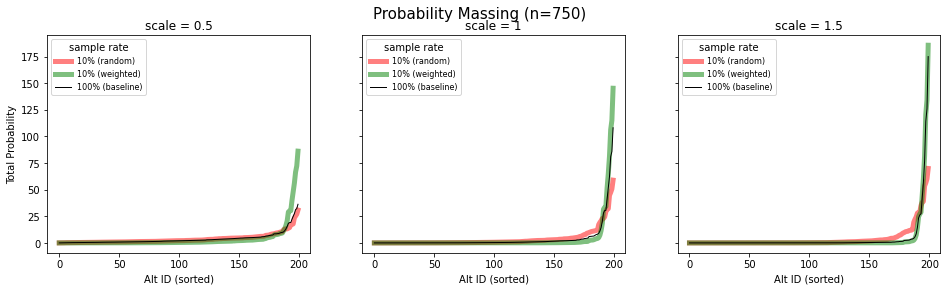

In [80]:
fig, axarr = plt.subplots(1, 3, figsize=(16,4), sharey=True)
for i, scale in enumerate([0.5, 1, 1.5]):
    ax = axarr[i]
    results = vmap(
                    lmnl.interaction_probs_all, in_axes=(None, None, None, 0))(
                    alts, coeffs, scale, (choosers, keys))

    results2 = vmap(
                    lmnl.interaction_probs_all_weighted, in_axes=(None, None, None, 0))(
                    alts, coeffs, scale, (choosers, keys))
    

    ax.plot(np.arange(num_alts), np.sort(onp.array(results[:,0,:].sum(axis=0))), c='r', label='10% (random)', lw=5, alpha=0.5)
    ax.plot(np.arange(num_alts), np.sort(onp.array(results2[:,0,:].sum(axis=0))), c='g', label='10% (weighted)', lw=5, alpha=0.5)
    ax.plot(np.arange(num_alts), np.sort(onp.array(results[:,9,:].sum(axis=0))), c='k', label='100% (baseline)', lw=1)
    ax.legend(title='sample rate', fontsize=8, loc='upper left')
    ax.set_title("scale = {0}".format(scale))
    ax.set_xlabel("Alt ID (sorted)")
axarr[0].set_ylabel("Total Probability")
fig.suptitle("Probability Massing (n=750)", fontsize=15)

Text(0.5, 0.98, 'Probability Massing (n=750)')

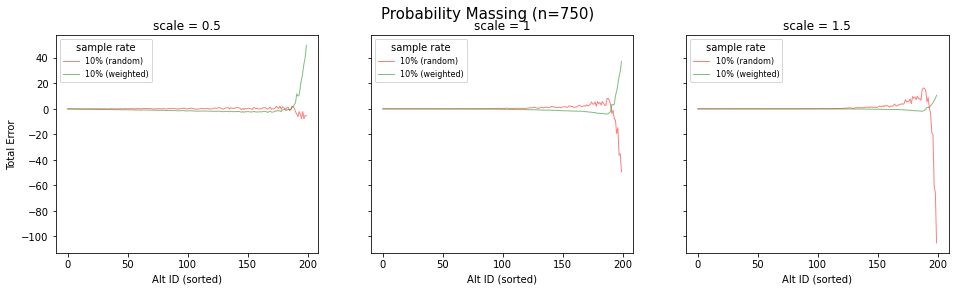

In [135]:
fig, axarr = plt.subplots(1, 3, figsize=(16,4), sharey=True)
for i, scale in enumerate([0.5, 1, 1.5]):
    ax = axarr[i]
    results = vmap(
                    lmnl.interaction_probs_all, in_axes=(None, None, None, 0))(
                    alts, coeffs, scale, (choosers, keys))

    results2 = vmap(
                    lmnl.interaction_probs_all_weighted, in_axes=(None, None, None, 0))(
                    alts, coeffs, scale, (choosers, keys))
    true_mass = onp.array(results[:,9,:].sum(axis=0))
    true_order = np.argsort(true_mass)
    
    rand_mass = onp.array(results[:,0,:].sum(axis=0))
    rand_err = (rand_mass[true_order] - true_mass[true_order])
    
    wgt_mass = onp.array(results2[:,0,:].sum(axis=0))
    wgt_err = (wgt_mass[true_order] - true_mass[true_order])

    ax.plot(np.arange(num_alts), rand_err, c='r', label='10% (random)', lw=1, alpha=0.5)
    ax.plot(np.arange(num_alts), wgt_err, c='g', label='10% (weighted)', lw=1, alpha=0.5)
    ax.legend(title='sample rate', fontsize=8, loc='upper left')
    ax.set_title("scale = {0}".format(scale))
    ax.set_xlabel("Alt ID (sorted)")
axarr[0].set_ylabel("Total Error")
fig.suptitle("Probability Massing (n=750)", fontsize=15)

Text(0.5, 0.98, 'Probability Massing (n=750)')

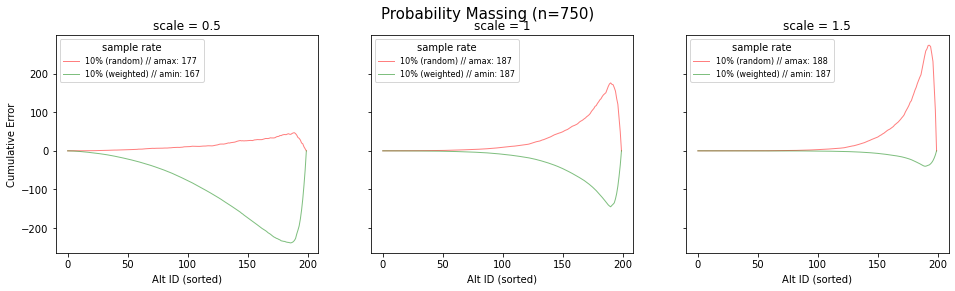

In [143]:
fig, axarr = plt.subplots(1, 3, figsize=(16,4), sharey=True)
for i, scale in enumerate([0.5, 1, 1.5]):
    ax = axarr[i]
    results = vmap(
                    lmnl.interaction_probs_all, in_axes=(None, None, None, 0))(
                    alts, coeffs, scale, (choosers, keys))

    results2 = vmap(
                    lmnl.interaction_probs_all_weighted, in_axes=(None, None, None, 0))(
                    alts, coeffs, scale, (choosers, keys))
    true_mass = onp.array(results[:,9,:].sum(axis=0))
    true_order = np.argsort(true_mass)
    
    rand_mass = onp.array(results[:,0,:].sum(axis=0))
    rand_err = (rand_mass[true_order] - true_mass[true_order])
    
    wgt_mass = onp.array(results2[:,0,:].sum(axis=0))
    wgt_err = (wgt_mass[true_order] - true_mass[true_order])

    amax = np.argmax(rand_err)
    amin = np.argmin(wgt_err)
    
    ax.plot(np.arange(num_alts), np.cumsum(rand_err), c='r', label='10% (random) // amax: {0}'.format(amax), lw=1, alpha=0.5)
    ax.plot(np.arange(num_alts), np.cumsum(wgt_err), c='g', label='10% (weighted) // amin: {0}'.format(amin), lw=1, alpha=0.5)
    ax.legend(title='sample rate', fontsize=8, loc='upper left')
    ax.set_title("scale = {0}".format(scale))
    ax.set_xlabel("Alt ID (sorted)")
axarr[0].set_ylabel("Cumulative Error")
fig.suptitle("Probability Massing (n=750)", fontsize=15)

Text(0.5, 0.98, 'Cumulative Probability Massing (n=750)')

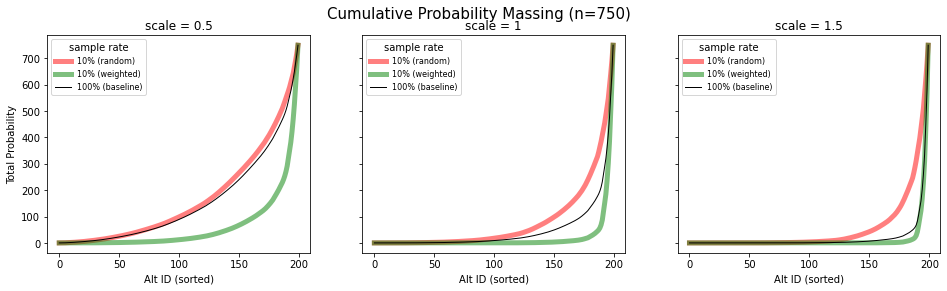

In [86]:
fig, axarr = plt.subplots(1, 3, figsize=(16,4), sharey=True)
for i, scale in enumerate([0.5, 1, 1.5]):
    ax = axarr[i]
    results = vmap(
                    lmnl.interaction_probs_all, in_axes=(None, None, None, 0))(
                    alts, coeffs, scale, (choosers, keys))

    results2 = vmap(
                    lmnl.interaction_probs_all_weighted, in_axes=(None, None, None, 0))(
                    alts, coeffs, scale, (choosers, keys))
    

    ax.plot(np.arange(num_alts), onp.cumsum(onp.sort(onp.array(results[:,0,:].sum(axis=0)))), c='r', label='10% (random)', lw=5, alpha=0.5)
    ax.plot(np.arange(num_alts), onp.cumsum(onp.sort(onp.array(results2[:,0,:].sum(axis=0)))), c='g', label='10% (weighted)', lw=5, alpha=0.5)
    ax.plot(np.arange(num_alts), onp.cumsum(onp.sort(onp.array(results[:,9,:].sum(axis=0)))), c='k', label='100% (baseline)', lw=1)
    ax.legend(title='sample rate', fontsize=8, loc='upper left')
    ax.set_title("scale = {0}".format(scale))
    ax.set_xlabel("Alt ID (sorted)")
axarr[0].set_ylabel("Total Probability")
fig.suptitle("Cumulative Probability Massing (n=750)", fontsize=15)

In [9]:
results = vmap(
                    lmnl.interaction_probs_all, in_axes=(None, None, None, 0))(
                    alts, coeffs, 1, (choosers, keys))

In [10]:
results2 = lmnl.get_all_probs(
    choosers, alts, coeffs, key, scale=1, batched=True, verbose=False)

In [20]:
results[:,-1,:].sum(axis=0).std()

DeviceArray(9.763212, dtype=float32)

In [18]:
results2[-1,:].std()

DeviceArray(9.763212, dtype=float32)

In [ ]:
fig, axarr = plt.subplots(1, 3, figsize=(16,4), sharey=True)
for i, scale in enumerate([0.5, 1, 1.5]):
    ax = axarr[i]
    results = vmap(
                    lmnl.interaction_probs_all, in_axes=(None, None, None, 0))(
                    alts, coeffs, scale, (choosers, keys))

    results2 = vmap(
                    lmnl.interaction_probs_all_weighted, in_axes=(None, None, None, 0))(
                    alts, coeffs, scale, (choosers, keys))
    

    ax.plot(np.arange(num_alts), onp.cumsum(onp.array(results[:,0,:].sum(axis=0))) / num_choosers, c='r', label='10% (random)', lw=5, alpha=0.5)
    ax.plot(np.arange(num_alts), onp.cumsum(onp.array(results2[:,0,:].sum(axis=0)) / num_choosers), c='g', label='10% (weighted)', lw=5, alpha=0.5)
    ax.plot(np.arange(num_alts), onp.cumsum(onp.array(results[:,9,:].sum(axis=0)) / num_choosers), c='k', label='100% (baseline)', lw=1)
    ax.legend(title='sample rate', fontsize=8, loc='upper left')
    ax.set_title("scale = {0}".format(scale))
    ax.set_xlabel("Alt ID")
    if scale == 1:
        break
axarr[0].set_ylabel("% Probability Mass")
fig.suptitle("Cumulative Probability Massing (n=750)", fontsize=15)

Text(0.5, 0.98, 'Cumulative Probability Massing (n=750)')

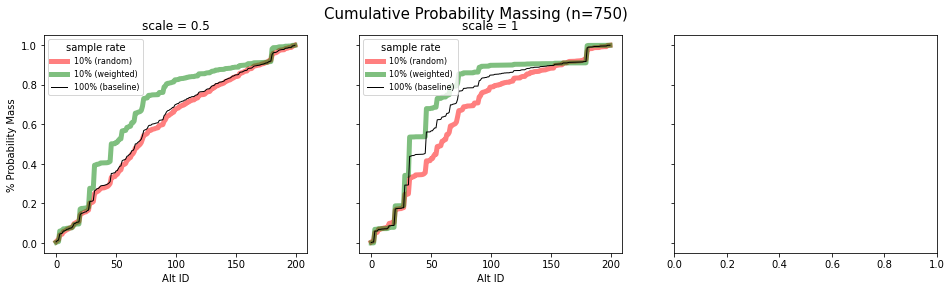

In [200]:
fig, axarr = plt.subplots(1, 3, figsize=(16,4), sharey=True)
for i, scale in enumerate([0.5, 1, 1.5]):
    ax = axarr[i]
    results = vmap(
                    lmnl.interaction_probs_all, in_axes=(None, None, None, 0))(
                    alts, coeffs, scale, (choosers, keys))

    results2 = vmap(
                    lmnl.interaction_probs_all_weighted, in_axes=(None, None, None, 0))(
                    alts, coeffs, scale, (choosers, keys))
    

    ax.plot(np.arange(num_alts), onp.cumsum(onp.array(results[:,0,:].sum(axis=0))) / num_choosers, c='r', label='10% (random)', lw=5, alpha=0.5)
    ax.plot(np.arange(num_alts), onp.cumsum(onp.array(results2[:,0,:].sum(axis=0)) / num_choosers), c='g', label='10% (weighted)', lw=5, alpha=0.5)
    ax.plot(np.arange(num_alts), onp.cumsum(onp.array(results[:,9,:].sum(axis=0)) / num_choosers), c='k', label='100% (baseline)', lw=1)
    ax.legend(title='sample rate', fontsize=8, loc='upper left')
    ax.set_title("scale = {0}".format(scale))
    ax.set_xlabel("Alt ID")
    if scale == 1:
        break
axarr[0].set_ylabel("% Probability Mass")
fig.suptitle("Cumulative Probability Massing (n=750)", fontsize=15)

In [201]:
onp.array(results[:,0,:].sum(axis=0)).std()


8.675457

In [204]:
results2[:,0,:].sum(axis=0).shape

(200,)

In [202]:
onp.array(results2[:,0,:].sum(axis=0)).std()

17.352274

In [203]:
onp.array(results2[:,9,:].sum(axis=0)).std()

13.243889

Text(0.5, 1.0, 'scale = 1')

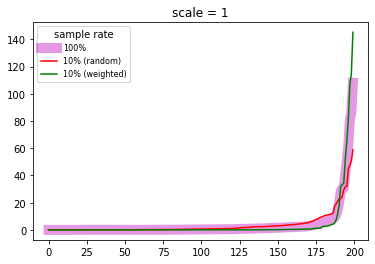

In [57]:
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,9,:].sum(axis=0))), c='m', label='100%', lw=10, alpha=0.4)
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,0,:].sum(axis=0))), c='r', label='10% (random)')
plt.plot(np.arange(num_alts), np.sort(onp.array(results2[:,0,:].sum(axis=0))), c='g', label='10% (weighted)')
plt.legend(title='sample rate', fontsize=8)
plt.title("scale = 1")

Text(0.5, 1.0, '30% sample')

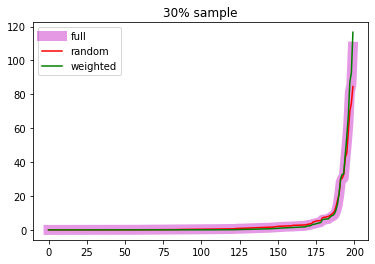

In [37]:
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,9,:].sum(axis=0))), c='m', label='full', lw=10, alpha=0.4)
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,2,:].sum(axis=0))), c='r', label='random')
# plt.plot(np.arange(num_alts), np.sort(onp.array(results2[:,4,:].sum(axis=0))), c='b', label='random + max')
plt.plot(np.arange(num_alts), np.sort(onp.array(results3[:,2,:].sum(axis=0))), c='g', label='weighted')
plt.legend()
plt.title("30% sample")

Text(0.5, 1.0, '50% sample')

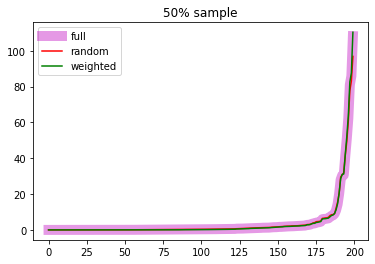

In [35]:
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,9,:].sum(axis=0))), c='m', label='full', lw=10, alpha=0.4)
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,4,:].sum(axis=0))), c='r', label='random')
# plt.plot(np.arange(num_alts), np.sort(onp.array(results2[:,4,:].sum(axis=0))), c='b', label='random + max')
plt.plot(np.arange(num_alts), np.sort(onp.array(results3[:,4,:].sum(axis=0))), c='g', label='weighted')
plt.legend()
plt.title("50% sample")

# Scale = 0.5

In [58]:
results = vmap(
                lmnl.interaction_probs_all, in_axes=(None, None, None, 0))(
                alts, coeffs, .5, (choosers, keys))

results2 = vmap(
                lmnl.interaction_probs_all_weighted, in_axes=(None, None, None, 0))(
                alts, coeffs, .5, (choosers, keys))

Text(0.5, 1.0, 'scale = 0.5')

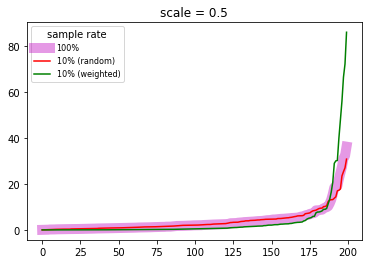

In [60]:
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,9,:].sum(axis=0))), c='m', label='100%', lw=10, alpha=0.4)
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,0,:].sum(axis=0))), c='r', label='10% (random)')
plt.plot(np.arange(num_alts), np.sort(onp.array(results2[:,0,:].sum(axis=0))), c='g', label='10% (weighted)')
plt.legend(title='sample rate', fontsize=8)
plt.title("scale = 0.5")

Text(0.5, 1.0, '30% sample')

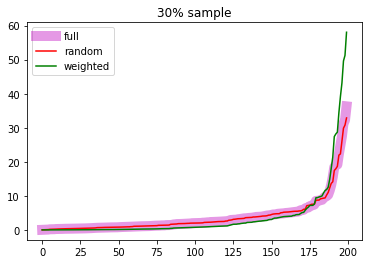

In [40]:
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,9,:].sum(axis=0))), c='m', label='full', lw=10, alpha=0.4)
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,2,:].sum(axis=0))), c='r', label='random')
plt.plot(np.arange(num_alts), np.sort(onp.array(results2[:,2,:].sum(axis=0))), c='g', label='weighted')
plt.legend()
plt.title("30% sample")

Text(0.5, 1.0, '50% sample')

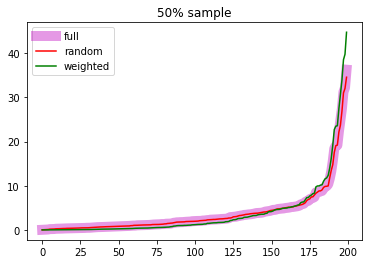

In [41]:
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,9,:].sum(axis=0))), c='m', label='full', lw=10, alpha=0.4)
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,4,:].sum(axis=0))), c='r', label='random')
plt.plot(np.arange(num_alts), np.sort(onp.array(results2[:,4,:].sum(axis=0))), c='g', label='weighted')
plt.legend()
plt.title("50% sample")

# Scale 1.5

In [61]:
results = vmap(
                lmnl.interaction_probs_all, in_axes=(None, None, None, 0))(
                alts, coeffs, 1.5, (choosers, keys))

results2 = vmap(
                lmnl.interaction_probs_all_weighted, in_axes=(None, None, None, 0))(
                alts, coeffs, 1.5, (choosers, keys))

Text(0.5, 1.0, 'scale = 1.5')

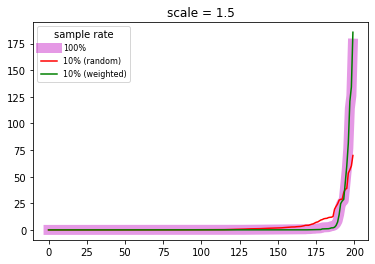

In [62]:
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,9,:].sum(axis=0))), c='m', label='100%', lw=10, alpha=0.4)
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,0,:].sum(axis=0))), c='r', label='10% (random)')
plt.plot(np.arange(num_alts), np.sort(onp.array(results2[:,0,:].sum(axis=0))), c='g', label='10% (weighted)')
plt.legend(title='sample rate', fontsize=8)
plt.title("scale = 1.5")

Text(0.5, 1.0, '30% sample')

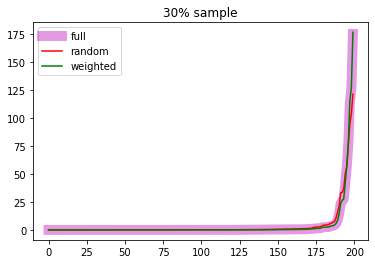

In [46]:
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,9,:].sum(axis=0))), c='m', label='full', lw=10, alpha=0.4)
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,2,:].sum(axis=0))), c='r', label='random')
plt.plot(np.arange(num_alts), np.sort(onp.array(results2[:,2,:].sum(axis=0))), c='g', label='weighted')
plt.legend()
plt.title("30% sample")

Text(0.5, 1.0, '50% sample')

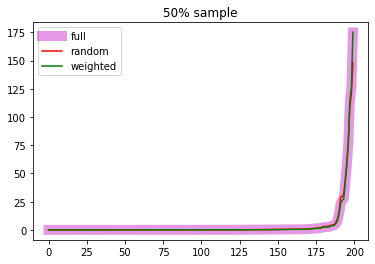

In [48]:
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,9,:].sum(axis=0))), c='m', label='full', lw=10, alpha=0.4)
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,4,:].sum(axis=0))), c='r', label='random')
plt.plot(np.arange(num_alts), np.sort(onp.array(results2[:,4,:].sum(axis=0))), c='g', label='weighted')
plt.legend()
plt.title("50% sample")